<a href="https://colab.research.google.com/github/mattia-robbiano/course_deeplearning/blob/main/robbiano_mattia_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fully-connected Neural Network

## Imports and pre processing

In [ ]:
#standard imports
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#to compute silhouette score
from sklearn.metrics import silhouette_samples

In [ ]:
# Load the MNIST dataset
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Split the training set into training and validation sets
val_size = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size, stratify=Y_train)

# Reshape and normalize the input data
X_train = X_train.reshape(X_train.shape[0], -1).T / 255.0
X_val = X_val.reshape(X_val.shape[0], -1).T / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).T / 255.0

m, n = X_train.shape

11490434/11490434 [==============================] - 0s 0us/step


## Define model and metrics


In [ ]:
#to get lables in one hot encoding
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [ ]:
#initialize weights randomly
def init():
  W1 = np.random.rand(10,784)-0.5 #np.random.rand gives random numbers between 0 and 1
  B1 = np.random.rand(10,1)-0.5
  W2 = np.random.rand(10,10)-0.5
  B2 = np.random.rand(10,1)-0.5
  return W1, B1, W2, B2

In [ ]:
def ReLU(X):
  return np.maximum(0,X)

In [ ]:
def softmax(X):
    exp_scores = np.exp(X)
    return exp_scores / np.sum(exp_scores, axis=0)

In [ ]:
def forward_prop(X, W1, B1, W2, B2):
    Z1 = np.dot(W1, X) + B1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + B2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [ ]:
def ReLU_deriv(X):
    return X > 0

In [ ]:
def back_prop(X, Y, A1, Z1, A2, Z2, W2):
    Y = one_hot(Y)
    m = X.shape[1]
    dZ2 = A2 - Y #loss: 1/2 (A2 - Y)^2
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    dB2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * ReLU_deriv(Z1)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    dB1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, dB1, dW2, dB2

In [ ]:
def gradient_descent(W1, B1, W2, B2, dW1, dB1, dW2, dB2, learning_rate):

    W1 -= learning_rate * dW1
    B1 -= learning_rate * dB1
    W2 -= learning_rate * dW2
    B2 -= learning_rate * dB2
    return W1, B1, W2, B2

In [ ]:
#collapse A1 in one row. The values are the number of the row in A2 in which the probability is maximum
def get_predictions(A2):
  return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
  return np.sum(predictions == Y) / Y.size

def get_loss(y_pred, y_true):
  return np.mean(0.5*(y_pred - y_true)**2)

def make_predictions(X, W1, B1, W2, B2):
    _, _, _, A2 = forward_prop(X, W1, B1, W2, B2)
    predictions = get_predictions(A2)
    return predictions

#function to compute silhouette score given the transformed matrix and the true lables
def get_silhouette (X, Y):
  sample_silhouette_values = silhouette_samples(X.T, Y)
  means = []
  for label in range(10):
    means.append(sample_silhouette_values[Y == label].mean())
  return means

In [ ]:
def get_A2(X, W1, B1, W2, B2):
  _, _, _, A2 = forward_prop(X, W1, B1, W2, B2)
  return A2


## Training

In [ ]:
def train(X, Y, Xval, Yval, num_epochs, initial_learning_rate):
    W1, B1, W2, B2 = init()

    global accuracy_train
    global accuracy_val
    global loss_train
    global loss_val
    global silhouette
    accuracy_train = np.empty(int(num_epochs/10))
    accuracy_val = np.empty(int(num_epochs/10))
    loss_train = np.empty(int(num_epochs/10))
    loss_val = np.empty(int(num_epochs/10))
    silhouette = np.empty([int(num_epochs/50),10])

    for epoch in range(num_epochs):
        #dacading learning rate
        decay_rate = 0.01
        learning_rate = initial_learning_rate / (1 + decay_rate * epoch)

        # Forward propagation
        Z1, A1, Z2, A2 = forward_prop(X, W1, B1, W2, B2)

        # Backpropagation
        dW1, dB1, dW2, dB2 = back_prop(X, Y, A1, Z1, A2, Z2, W2)

        # Update parameters
        W1, B1, W2, B2 = gradient_descent(W1, B1, W2, B2, dW1, dB1, dW2, dB2, learning_rate)

        if epoch % 10 == 0:
            print("\n Epoch: ", epoch)

            #metriche per training set
            train_predictions = get_predictions(A2)
            acc = get_accuracy(train_predictions, Y)
            loss = get_loss(train_predictions, Y)
            print("Training loss:", loss)
            print("Training accuracy", acc)
            accuracy_train[int(epoch/10)] = acc
            loss_train[int(epoch/10)] = loss


            #metriche per validation set
            val_predictions = make_predictions(Xval, W1, B1, W2, B2)
            acc = get_accuracy(val_predictions, Yval)
            loss = get_loss(val_predictions, Yval)
            print("Validation loss:", loss)
            print("Validation accuracy", acc)
            accuracy_val[int(epoch/10)] = acc
            loss_val[int(epoch/10)] = loss

        '''if epoch % 50 == 0:

          #da implementare vettore di silhouette scores per
          silhouette_avg = get_silhouette(A2,Y)
          silhouette[int(epoch/50), :] = silhouette_avg
          print("Training silhouette score:", silhouette_avg)'''





    return W1, B1, W2, B2

In [ ]:
W1, B1, W2, B2 = train(X_train, Y_train, X_val, Y_val, 1000, 0.5)


 Epoch:  0
Training loss: 10.212296296296296
Training accuracy 0.0765
Validation loss: 7.45125
Validation accuracy 0.17033333333333334

 Epoch:  10
Training loss: 4.470296296296296
Training accuracy 0.4837222222222222
Validation loss: 4.38375
Validation accuracy 0.5075

 Epoch:  20
Training loss: 3.087759259259259
Training accuracy 0.6445555555555555
Validation loss: 3.05275
Validation accuracy 0.6591666666666667

 Epoch:  30
Training loss: 3.6123796296296296
Training accuracy 0.6203888888888889
Validation loss: 2.7754166666666666
Validation accuracy 0.6656666666666666

 Epoch:  40
Training loss: 2.586537037037037
Training accuracy 0.7091111111111111
Validation loss: 2.425666666666667
Validation accuracy 0.7168333333333333

 Epoch:  50
Training loss: 2.1149444444444443
Training accuracy 0.756
Validation loss: 2.0541666666666667
Validation accuracy 0.7565

 Epoch:  60
Training loss: 1.9007777777777777
Training accuracy 0.7771111111111111
Validation loss: 1.8750833333333334
Validation a

KeyboardInterrupt: ignored

## Performance

In [ ]:
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    normalized_vector = vector
    return normalized_vector

In [ ]:
#Print metrics for training set and validation set
plt.plot(normalize_vector(accuracy_train), label = 'train accuracy')
plt.plot(normalize_vector(accuracy_val), label = 'validation accuracy')
plt.plot(normalize_vector(loss_train), label = 'train loss')
plt.plot(normalize_vector(loss_val), label = 'validation loss')
plt.xlabel('epoch/10')
plt.legend(fontsize=15);
plt.show()

In [ ]:
test_predictions = make_predictions(X_test, W1, B1, W2, B2)
acc = get_accuracy(test_predictions, Y_test)
loss = get_loss(test_predictions, Y_test)
print("Validation loss:", loss)
print("Validation accuracy", acc)

Validation loss: 0.8905
Validation accuracy 0.8909


## Silhouette score

In [ ]:
#Grafico il silhouette score per ogni classe
plt.title("Silhouette score after second layer A2")
plt.xlabel('epoch/50')
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
for i in range(9):
    plt.plot(silhouette[:,i], label=labels[i])
plt.legend()
plt.show()


In [ ]:
#silhouette score for X test
print( get_silhouette(X_test,Y_test))


## PCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt



# Apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_train.T, Y_train)


In [ ]:
# Create a list of colors for each cluster label
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'pink']
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# Plot the transformed data in 3D with different colors for each cluster
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(300):
    ax.scatter(principal_components[i, 0], principal_components[i, 1], principal_components[i, 2], color=colors[Y_train[i]])
r_patch = mpatches.Patch(color='red',     label='0')
b_patch = mpatches.Patch(color='blue',    label='1')
g_patch = mpatches.Patch(color='green',   label='2')
o_patch = mpatches.Patch(color='orange',  label='3')
p_patch = mpatches.Patch(color='purple',  label='4')
y_patch = mpatches.Patch(color='yellow',  label='5')
c_patch = mpatches.Patch(color='cyan',    label='6')
m_patch = mpatches.Patch(color='magenta', label='7')
l_patch = mpatches.Patch(color='lime',    label='8')
p_patch = mpatches.Patch(color='pink',    label='9')


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA Visualization in 3D with Clusters')

plt.legend(handles=[r_patch,b_patch,g_patch,o_patch,p_patch,y_patch,c_patch,m_patch,l_patch,p_patch])

plt.show()

In [ ]:
#ricavo A2 da W2
A2 = get_A2(X_train, W1, B1, W2, B2)

In [ ]:
# Apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
principal_components_A2 = pca.fit_transform(A2.T, Y_train)

# Create a list of colors for each cluster label
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'pink']

# Plot the transformed data in 3D with different colors for each cluster
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(300):
    ax.scatter(principal_components_A2[i, 0], principal_components_A2[i, 1], principal_components_A2[i, 2], color=colors[Y_train[i]])
r_patch = mpatches.Patch(color='red',     label='0')
b_patch = mpatches.Patch(color='blue',    label='1')
g_patch = mpatches.Patch(color='green',   label='2')
o_patch = mpatches.Patch(color='orange',  label='3')
p_patch = mpatches.Patch(color='purple',  label='4')
y_patch = mpatches.Patch(color='yellow',  label='5')
c_patch = mpatches.Patch(color='cyan',    label='6')
m_patch = mpatches.Patch(color='magenta', label='7')
l_patch = mpatches.Patch(color='lime',    label='8')
p_patch = mpatches.Patch(color='pink',    label='9')


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA Visualization in 3D with Clusters')

plt.legend(handles=[r_patch,b_patch,g_patch,o_patch,p_patch,y_patch,c_patch,m_patch,l_patch,p_patch])

plt.show()

# Convolutional Neural Network

In [ ]:
%reset -f


## Imports and pre processing

In [ ]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

#import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback

#import PCA analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

#import metrics
from sklearn.metrics import silhouette_samples

#function for fast generation of training and test set from data
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist

In [ ]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Split the training set into training and validation sets
val_size = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size, stratify=Y_train)

# Reshape and normalize the input data
X_train = X_train/ 255.0
X_val = X_val/ 255.0
X_test = X_test/ 255.0

#transform integer label into one-hot encodings
n_classes=10

y_train_cat = keras.utils.to_categorical(Y_train, n_classes)
y_val_cat = keras.utils.to_categorical(Y_val, n_classes)
y_test_cat = keras.utils.to_categorical(Y_test, n_classes)

11490434/11490434 [==============================] - 0s 0us/step


## Model set up

In [ ]:
#import generic model class
from tensorflow.keras import Model, Input

#import the types of layes we need
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Reshape

In [ ]:
#cleares the backend of all the previous instances of the models
keras.backend.clear_session()

#input shape
inputs = Input(shape=(28,28))
x = Reshape(target_shape=(28,28,1))(inputs)

#convolutional 1
x = Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu')(x)

#Pooling (padding valid means no padding happening)
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#reshape input for fully connected
x = Flatten()(x)

#add a hidden dense layer
x = Dense(15, activation='tanh')(x)

#output layer with softmax for classification
outputs = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name='basic_convolution')

In [ ]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer='sgd',
    metrics=['accuracy']
)

In [ ]:
model.summary()

## Training and metrics

In [ ]:
class GetWeightsCallback(Callback):
  def __init__(self, file_path):
    self.file_path = file_path
    self.counter = 0

  def on_epoch_begin(self, epoch, logs=None):
    self.counter += 1
    file_path_iter = self.file_path + str(self.counter)
    if self.counter % 2 == 0:
      weights = self.model.get_weights()
      self.model.save_weights(file_path_iter, overwrite=True)

file_path = "/content/dati/pesi"

weights_callback = GetWeightsCallback(file_path)

# history = model.fit(X_train, y_train_cat, validation_data=(X_val,y_val_cat), epochs=200, callbacks=[weights_callback])
history = model.fit(X_train, y_train_cat, validation_data=(X_val,y_val_cat), epochs=200)

Epoch 1/200
1688/1688 [==============================] - 42s 24ms/step - loss: 0.0894 - accuracy: 0.1623 - val_loss: 0.0882 - val_accuracy: 0.2590
Epoch 2/200
1688/1688 [==============================] - 32s 19ms/step - loss: 0.0859 - accuracy: 0.3824 - val_loss: 0.0824 - val_accuracy: 0.4857
Epoch 3/200
1688/1688 [==============================] - 31s 18ms/step - loss: 0.0748 - accuracy: 0.5519 - val_loss: 0.0658 - val_accuracy: 0.5962
Epoch 4/200
1688/1688 [==============================] - 33s 19ms/step - loss: 0.0580 - accuracy: 0.6486 - val_loss: 0.0520 - val_accuracy: 0.6803
Epoch 5/200
1688/1688 [==============================] - 31s 18ms/step - loss: 0.0475 - accuracy: 0.7167 - val_loss: 0.0441 - val_accuracy: 0.7435
Epoch 6/200
1688/1688 [==============================] - 32s 19ms/step - loss: 0.0409 - accuracy: 0.7733 - val_loss: 0.0388 - val_accuracy: 0.7950
Epoch 7/200
1688/1688 [==============================] - 32s 19ms/step - loss: 0.0363 - accuracy: 0.8101 - val_loss: 0

In [ ]:
#evaluate model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 2s 7ms/step - loss: 0.0044 - accuracy: 0.9736

Test Loss:	 0.004393014125525951
Test Accuracy:	 0.9735999703407288


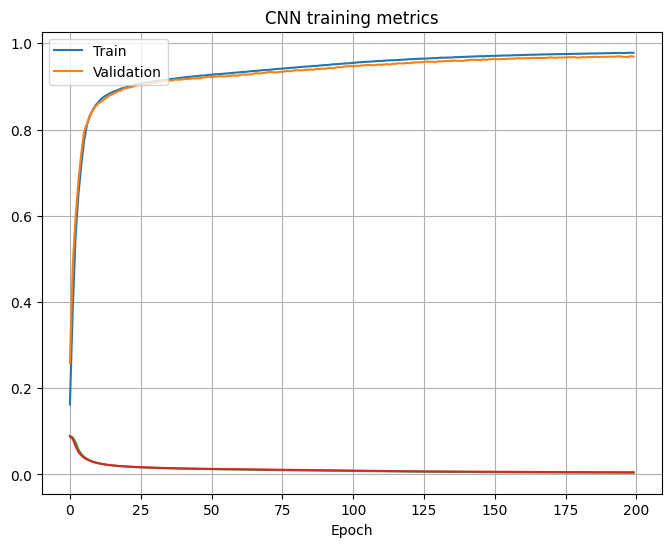

In [ ]:
#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel('Epoch')
plt.title('CNN training metrics')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'], loc='upper left')
ax.grid()

##Silhouette Score

In [ ]:
def get_silhouette (X, Y):
  sample_silhouette_values = silhouette_samples(X.T, Y)
  means = []
  for label in range(10):
    means.append(sample_silhouette_values[Y == label].mean())
  return means

In [ ]:
  #file_path_iter = "/content/dati/pesi"+str(200)
  #model.load_weights(file_path_iter, skip_mismatch=False, by_name=False, options=None)
  # perform forward pass and get output
  output = model.predict(X_test)
  #evaluate silhouette score
  silhouette = get_silhouette(output.T,Y_test)


313/313 [==============================] - 2s 7ms/step


In [ ]:
print(silhouette)

[0.9334562, 0.9209666, 0.8463842, 0.87290025, 0.8846542, 0.86593354, 0.8681173, 0.8437506, 0.8403045, 0.8130455]


In [ ]:
  silhouette_vector = np.empty([10,25])
#for i in range(1,26):
  #carica i pesi
  file_path_iter = "/content/dati/pesi"+str()
  model.load_weights(file_path_iter, skip_mismatch=False, by_name=False, options=None)
  # perform forward pass and get output
  output = model.predict(X_test)
  #evaluate silhouette score
  silhouette = get_silhouette(output.T,Y_test)
  silhouette_vector[:,i-1] = np.array(silhouette)

NotFoundError: ignored

In [ ]:

#Grafico il silhouette score per ogni classe
plt.title("Silhouette score after second layer A2")
plt.xlabel('epoch/2')
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
for i in range(9):
  plt.plot(silhouette_vector[i,:], label=labels[i])
plt.legend()
plt.show()


##PCA

In [ ]:
#carica i pesi
#file_path_iter = "/content/dati/pesi"+str(2)
#model.load_weights(file_path_iter, skip_mismatch=False, by_name=False, options=None)

# perform forward pass and get output
output = model.predict(X_train)



1688/1688 [==============================] - 17s 10ms/step


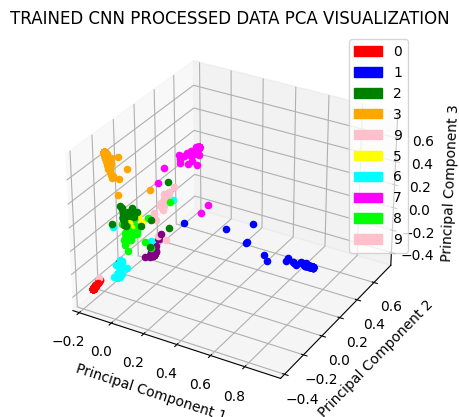

In [ ]:
# Apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
principal_components = pca.fit_transform(output, Y_train)
# Create a list of colors for each cluster label
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'pink']
lables = ['0','1','2','3','4','5','6','7','8','9']

# Plot the transformed data in 3D with different colors for each cluster
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(1000):
    scatter = ax.scatter(principal_components[i, 0], principal_components[i, 1], principal_components[i, 2], color=colors[Y_train[i]])

r_patch = mpatches.Patch(color='red',     label='0')
b_patch = mpatches.Patch(color='blue',    label='1')
g_patch = mpatches.Patch(color='green',   label='2')
o_patch = mpatches.Patch(color='orange',  label='3')
p_patch = mpatches.Patch(color='purple',  label='4')
y_patch = mpatches.Patch(color='yellow',  label='5')
c_patch = mpatches.Patch(color='cyan',    label='6')
m_patch = mpatches.Patch(color='magenta', label='7')
l_patch = mpatches.Patch(color='lime',    label='8')
p_patch = mpatches.Patch(color='pink',    label='9')


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('TRAINED CNN PROCESSED DATA PCA VISUALIZATION')

plt.legend(handles=[r_patch,b_patch,g_patch,o_patch,p_patch,y_patch,c_patch,m_patch,l_patch,p_patch])

plt.show()